# Analyze HREMD for RNA tetramers

1. report acceptance/proposal ratio
2. plot replica mixing heat map
3. plot radius of gyration (Rg) histogram
4. plot rmsd (all, backbone only)
5. calculate J-coupling
6. bar plot of conformation population

https://github.com/choderalab/yank/blob/master/Yank/analyze.py  
https://github.com/choderalab/openmmtools/blob/main/openmmtools/multistate/multistatereporter.py  

In [1]:
import os, sys, math
import numpy as np
import glob
import mdtraj
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import warnings

#from openmmtools.multistate import ReplicaExchangeSampler, MultiStateReporter
import openmmtools as mmtools
from pymbar import timeseries
from openmm import *
from openmm.app import *
#from openmm.unit import *

import barnaba as bb
from barnaba import definitions
from barnaba.nucleic import Nucleic

In [2]:
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

In [3]:
mmtools.multistate.MultiStateReporter?

Init signature:
mmtools.multistate.MultiStateReporter(
    storage,
    open_mode=None,
    checkpoint_interval=50,
    checkpoint_storage=None,
    analysis_particle_indices=(),
)
Docstring:     
Handle storage write/read operations and different format conventions.

You can use this object to programmatically inspect the data generated by
ReplicaExchange.

Parameters
----------
storage : str
    The path to the storage file for analysis.

    A second checkpoint file will be determined from either ``checkpoint_storage`` or automatically based on
    the storage option

    In the future this will be able to take Storage classes as well.
open_mode : str or None
    The mode of the file between 'r', 'w', and 'a' (or equivalently 'r+').

    If None, the storage file won't be open on construction, and a call to
    :func:`Reporter.open` will be needed before attempting read/write operations.
checkpoint_interval : int >= 1, Default: 50
    The frequency at which checkpointing information

In [4]:
#reporter = mmtools.multistate.MultiStateReporter(ncfile, open_mode='r', checkpoint_interval=1)

In [5]:
backbone_sugar_atoms = [
    "C1'", \
    "H1'", \
    "C2'", \
    "H2'", \
    "C3'", \
    "H3'", \
    "C4'", \
    "H4'", \
    "C5'", \
    "H5'", \
    "H5''", \
    "O2'", \
    "HO2'", \
    "O3'", \
    "O4'", \
    "O5'", \
    "P", \
    "OP1", \
    "OP2", \
    "HO5'", \
    "HO3'"
]

In [6]:
# ==============================================================================
# Extract trajectory from NetCDF4 file
# https://github.com/choderalab/yank/blob/master/Yank/analyze.py
# ==============================================================================

def extract_trajectory(reference, nc_path, nc_checkpoint_file=None, checkpoint_interval=50, state_index=None, replica_index=None,
                       start_frame=0, end_frame=-1, skip_frame=1, keep_solvent=True,
                       discard_equilibration=False):
    """Extract phase trajectory from the NetCDF4 file.
    Parameters
    ----------
    reference : str
        Path to reference pdb file
    nc_path : str
        Path to the primary nc_file storing the analysis options
    nc_checkpoint_file : str or None, Optional
        File name of the checkpoint file housing the main trajectory
        Used if the checkpoint file is differently named from the default one chosen by the nc_path file.
        Default: None
    checkpoint_interval : int >= 1, Default: 50
        The frequency at which checkpointing information is written relative to analysis information.
        This is a multiple
        of the iteration at which energies is written, hence why it must be greater than or equal to 1.
        Checkpoint information cannot be written on iterations which where ``iteration % checkpoint_interval != 0``.
    state_index : int, optional
        The index of the alchemical state for which to extract the trajectory.
        One and only one between state_index and replica_index must be not None
        (default is None).
    replica_index : int, optional
        The index of the replica for which to extract the trajectory. One and
        only one between state_index and replica_index must be not None (default
        is None).
    start_frame : int, optional
        Index of the first frame to include in the trajectory (default is 0).
    end_frame : int, optional
        Index of the last frame to include in the trajectory. If negative, will
        count from the end (default is -1).
    skip_frame : int, optional
        Extract one frame every skip_frame (default is 1).
    keep_solvent : bool, optional
        If False, solvent molecules are ignored (default is True).
    discard_equilibration : bool, optional
        If True, initial equilibration frames are discarded (see the method
        pymbar.timeseries.detectEquilibration() for details, default is False).
    Returns
    -------
    trajectory: mdtraj.Trajectory
        The trajectory extracted from the netcdf file.
    """
    # Check correct input
    if (state_index is None) == (replica_index is None):
        raise ValueError('One and only one between "state_index" and '
                         '"replica_index" must be specified.')
    if not os.path.isfile(nc_path):
        raise ValueError('Cannot find file {}'.format(nc_path))

    # Import simulation data
    reporter = None
    try:
        reporter = mmtools.multistate.MultiStateReporter(nc_path, open_mode='r', checkpoint_storage=nc_checkpoint_file, checkpoint_interval=checkpoint_interval)
        reference = mdtraj.load_pdb(reference)
        topology = reference.topology
        
        # Get dimensions
        # Assume full iteration until proven otherwise
        last_checkpoint = True
        trajectory_storage = reporter._storage_checkpoint
        if not keep_solvent:
            # If tracked solute particles, use any last iteration, set with this logic test
            full_iteration = len(reporter.analysis_particle_indices) == 0
            if not full_iteration:
                trajectory_storage = reporter._storage_analysis
                topology = topology.subset(reporter.analysis_particle_indices)

        n_iterations = reporter.read_last_iteration(last_checkpoint=last_checkpoint)
        n_frames = trajectory_storage.variables['positions'].shape[0]
        n_atoms = trajectory_storage.variables['positions'].shape[2]
        logger.info('Number of frames: {}, atoms: {}'.format(n_frames, n_atoms))

        # Determine frames to extract.
        # Convert negative indices to last indices.
        if start_frame < 0:
            start_frame = n_frames + start_frame
        if end_frame < 0:
            end_frame = n_frames + end_frame + 1
        frame_indices = range(start_frame, end_frame, skip_frame)
        if len(frame_indices) == 0:
            raise ValueError('No frames selected')
        logger.info('Extracting frames from {} to {} every {}'.format(start_frame, end_frame, skip_frame))

        # Discard equilibration samples
        if discard_equilibration:
            u_n = extract_u_n(reporter._storage_analysis)
            # Discard frame 0 with minimized energy which throws off automatic equilibration detection.
            n_equil_iterations, g, n_eff = timeseries.detectEquilibration(u_n[1:])
            n_equil_iterations += 1
            logger.info(("Discarding initial {} equilibration samples (leaving {} "
                         "effectively uncorrelated samples)...").format(n_equil_iterations, n_eff))
            # Find first frame post-equilibration.
            if not full_iteration:
                for iteration in range(n_equil_iterations, n_iterations):
                    n_equil_frames = reporter._calculate_checkpoint_iteration(iteration)
                    if n_equil_frames is not None:
                        break
            else:
                n_equil_frames = n_equil_iterations
            frame_indices = frame_indices[n_equil_frames:-1]
        else:
            logging.info("Discard automatic equilibration detection")

        # Determine the number of frames that the trajectory will have.
        if state_index is None:
            n_trajectory_frames = len(frame_indices)
        else:
            # With SAMS, an iteration can have 0 or more replicas in a given state.
            # Deconvolute state indices.
            state_indices = [None for _ in frame_indices]
            for i, iteration in enumerate(frame_indices):
                replica_indices = reporter._storage_analysis.variables['states'][iteration, :]
                state_indices[i] = np.where(replica_indices == state_index)[0]
                #print(state_index, replica_indices, np.where(replica_indices == state_index)[0])
            n_trajectory_frames = sum(len(x) for x in state_indices)

        # Initialize positions and box vectors arrays.
        # MDTraj Cython code expects float32 positions.
        positions = np.zeros((n_trajectory_frames, n_atoms, 3), dtype=np.float32)
        box_vectors = np.zeros((n_trajectory_frames, 3, 3), dtype=np.float32)

        # Extract state positions and box vectors.
        if state_index is not None:
            logger.info('Extracting positions of state {}...'.format(state_index))

            # Extract state positions and box vectors.
            frame_idx = 0
            for i, iteration in enumerate(frame_indices):
                for replica_index in state_indices[i]:
                    positions[frame_idx, :, :] = trajectory_storage.variables['positions'][iteration, replica_index, :, :].astype(np.float32)
                    box_vectors[frame_idx, :, :] = trajectory_storage.variables['box_vectors'][iteration, replica_index, :, :].astype(np.float32)
                    frame_idx += 1

        else:  # Extract replica positions and box vectors
            logger.info('Extracting positions of replica {}...'.format(replica_index))

            for i, iteration in enumerate(frame_indices):
                positions[i, :, :] = trajectory_storage.variables['positions'][iteration, replica_index, :, :].astype(np.float32)
                box_vectors[i, :, :] = trajectory_storage.variables['box_vectors'][iteration, replica_index, :, :].astype(np.float32)
    finally:
        if reporter is not None:
            reporter.close()

    # Create trajectory object
    logger.info('Creating trajectory object...')
    trajectory = mdtraj.Trajectory(positions, topology)
    trajectory.unitcell_vectors = box_vectors

    return trajectory

In [7]:
def save_trajectory(reference, ncfile, state_index):
    traj = extract_trajectory(reference, ncfile, state_index=state_index, keep_solvent=False)
    ref = mdtraj.load_pdb(reference)
    traj.superpose(reference=ref, atom_indices = traj.topology.select('not (protein or water or symbol Na or symbol Cl)'))
    traj.save_netcdf('md_state{}.nc'.format(state_index))
    traj[-1].save_amberrst7('md_state{}.rst7'.format(state_index))
    traj[-1].save_pdb('md_state{}.pdb'.format(state_index))

In [8]:
def report_mixing(nc_path, nc_checkpoint_file=None):
    """Report state mixing.
    Parameters
    ----------
    nc_path : str
        Path to the primary nc_file storing the analysis options
    nc_checkpoint_file : str or None, Optional
        File name of the checkpoint file housing the main trajectory
        Used if the checkpoint file is differently named from the default one chosen by the nc_path file.
        Default: None
    Returns
    -------
    trajectory: mdtraj.Trajectory
        The trajectory extracted from the netcdf file.
    """
    reporter = mmtools.multistate.MultiStateReporter(nc_path, open_mode='r', checkpoint_storage=nc_checkpoint_file)
    n_accepted_matrix, n_proposed_matrix = reporter.read_mixing_statistics()
    n_swaps_proposed = n_proposed_matrix[1:].sum()
    n_swaps_accepted = n_accepted_matrix[1:].sum()

    swap_fraction_accepted = 0.0
    if n_swaps_proposed > 0:
        swap_fraction_accepted = float(n_swaps_accepted) / n_swaps_proposed
        print("Accepted {}/{} attemped swaps ({:.1f}%)".format(n_swaps_accepted, n_swaps_proposed, swap_fraction_accepted * 100))

    ratio = []
    # start from index 1 to remove nan
    for i in range(1, len(n_proposed_matrix)):
        v = float(n_accepted_matrix[i].sum() / n_proposed_matrix[i].sum())
        ratio.append(v)
        
    # mixing time plot
    fig = plt.figure(figsize=(12,6))
    plt.plot(np.arange(len(ratio)), ratio, c='k', lw=1, marker='.')
    plt.xlabel('iterations', fontsize=16)
    plt.ylabel('accceptance ratio', fontsize=16)
    plt.xlim(0, len(n_proposed_matrix))
    plt.ylim(0, np.max(ratio))
    plt.xticks(np.arange(0, len(n_proposed_matrix), 100), fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig('mixing_plt.png')
    #plt.show()
    #plt.clf()
    
    
    
    # 25 heatmaps
    i = int(len(n_accepted_matrix)/25)
    fig = plt.figure(figsize=(24,18))
    for j in range(25):
        k = j + 1
        ax = fig.add_subplot(5, 5, k)
        d = n_accepted_matrix[i*k]/n_proposed_matrix[i*k]
        g = sns.heatmap(d, cmap='Blues', square=False, annot=False, fmt=".1f", lw=0.1, linecolor='white', vmin=0, vmax=np.max(ratio), cbar=True)
        g.set(xticklabels=[])
        g.set(yticklabels=[])
        if j == 10:
            g.set_ylabel("states", fontsize=24)
        if j == 22:
            g.set_xlabel("states", fontsize=24)
        if j in [0, 5, 10, 15, 20]:
            g.set(yticklabels=np.arange(n_accepted_matrix.shape[-1]))
        if j in [20, 21, 22, 23, 24]:
            g.set(xticklabels=np.arange(n_accepted_matrix.shape[-1]))
        g.set_xticklabels(g.get_xmajorticklabels(), fontsize=18)
        g.set_yticklabels(g.get_ymajorticklabels(), fontsize=18)
        ax.set_xlim(0, len(d))
        ax.set_ylim(len(d), 0)
        ax.set_title("iteration #{}".format(str(i*k)), fontsize=18)

    for ax in fig.get_axes():
        ax.label_outer()
    plt.savefig('mixing_multi.png')
    #plt.clf()


    
    # heatmap of last iteration
    fig, ax = plt.subplots()
    d = n_accepted_matrix[-1]/n_proposed_matrix[-1]
    sns.heatmap(d, cmap='Blues', square=False, annot=False, fmt=".1f", lw=0.1, linecolor='white', vmin=0, vmax=np.max(ratio), cbar=True)
    ax.set_xlabel("states", fontsize=24)
    ax.set_ylabel("states", fontsize=24)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=18)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=18)
    ax.set_xlim(0, len(d))
    ax.set_ylim(len(d), 0)

    plt.tight_layout()
    plt.savefig('mixing.png')

In [9]:
def calc_rg(reference, ncfile, start_frame=0, end_frame=-1, skip_frame=1):
    
    ds = nc.Dataset(ncfile)
    n_states = ds.variables["states"].shape[1]    
    rg = []
    for i in range(n_states):
        t = extract_trajectory(reference, ncfile, start_frame=start_frame, end_frame=end_frame, skip_frame=skip_frame, state_index=i)
        atom_indices = t.topology.select('not (protein or water or symbol Na or symbol Cl)')
        t = t.atom_slice(atom_indices)
        rg += list(mdtraj.compute_rg(t))
    
    
    plt.hist(rg, bins=20, range=(0.5, 0.85), density=True)
    #plt.show()
    plt.savefig("rg.png")

In [25]:
def calc_rmsd(reference, ncfile, start_frame=0, end_frame=-1, skip_frame=1, state_index=None, heavy_atom=False):
    """
    Calculate rmsd between netcdf4 trajectory and a reference structure
    
    Parameter:
    ------------
    ncfile : Trajectory, netcdf4
        Trajectory exported by HREMD openmm
    reference : Structure file
        Reference strucuture used to calculate RMSD. Any format that can be loaded by mdtraj.load() is supported.
    state_index : int, (default: None)
        State index to extract trajectory. If a non-integer is given, then all states will be searched.
    heavy_atom :   bool, optional
         If True, all heavy atoms are used for superposition. Otherwise, backbone heavy atoms including ribose will be considered. Default is False. 
    
    Return
    -----------
    rmsd : list
        List of rmsd in nanometers
    """
    
    
    ref = mdtraj.load(reference)
    rmsd = []
    
    # specify state
    if isinstance(state_index, int):
        t = extract_trajectory(reference, ncfile, start_frame=start_frame, end_frame=end_frame, skip_frame=skip_frame, state_index=state_index)
        rmsd = list(bb.functions.rmsd_traj(ref, t))
    # loop all states
    else:
        ds = nc.Dataset(ncfile)
        n_states = ds.variables["states"].shape[1]
        for i in range(n_states):
            t = extract_trajectory(reference, ncfile, start_frame=start_frame, end_frame=end_frame, skip_frame=skip_frame, state_index=i)
            rmsd += list(bb.functions.rmsd_traj(ref, t))
    
    plt.plot(np.array(rmsd) * 10)
    plt.ylim(0, 6)
    plt.savefig("rmsd.png")    
    
    return rmsd

In [26]:
if __name__ == "__main__":
    reference = "../../eq/min.pdb"
    ncfile = "../enhanced.nc"
    #checkpoint_ncfile = "../enhanced_checkpoint.nc"
    start_frame = 1
    end_frame = -1
    skip_frame = 1

In [18]:
t = extract_trajectory(reference, ncfile, start_frame=start_frame, end_frame=end_frame, skip_frame=skip_frame, state_index=1)

In [ ]:
save_trajectory(reference, ncfile, state_index=5)

In [ ]:
report_mixing(ncfile)

In [ ]:
calc_rg(reference, ncfile, start_frame=start_frame, end_frame=end_frame, skip_frame=skip_frame)

# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


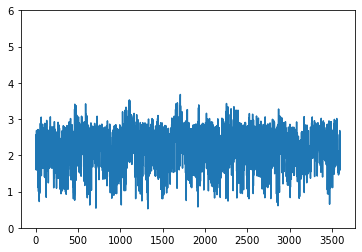

In [27]:
r = calc_rmsd(reference, ncfile, start_frame=start_frame, end_frame=end_frame, skip_frame=skip_frame, state_index=None)